In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx

import re
import os
import requests
import locale
import matplotlib.pyplot as plt
import seaborn as sns


import contextily as ctx
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

# Urban rail in Sofia, Bulgaria

## Yordan Marselev

### Abstract

The public transit landscape of Sofia, Bulgaria, stands on the verge of transformative transportation enhancements through the proposed urban rail network. This project evaluates six prospective rail lines as outlined in the article "Потенциал за шест линии" on the organization's website: [https://planzasofia.bg/план-за-софия/градски-транспорт/градската-железница-е-новият-трансп/потенциал-за-шест-линии]. 
The study analyzes the potential impact of these rail lines on the city's mobility, connectivity, and sustainable growth. Through assessment and comparative analysis, this research sheds light on the economic, environmental, and social implications of the proposed rail network. By considering factors such as ridership projection and infrastructure requirements, this project aims to provide valuable insights into the viability and desirability of each rail line. The findings presented contribute to the ongoing discourse on urban development, offering a foundation for informed decision-making and fostering a more accessible, efficient, and eco-friendly urban transport system in Sofia.

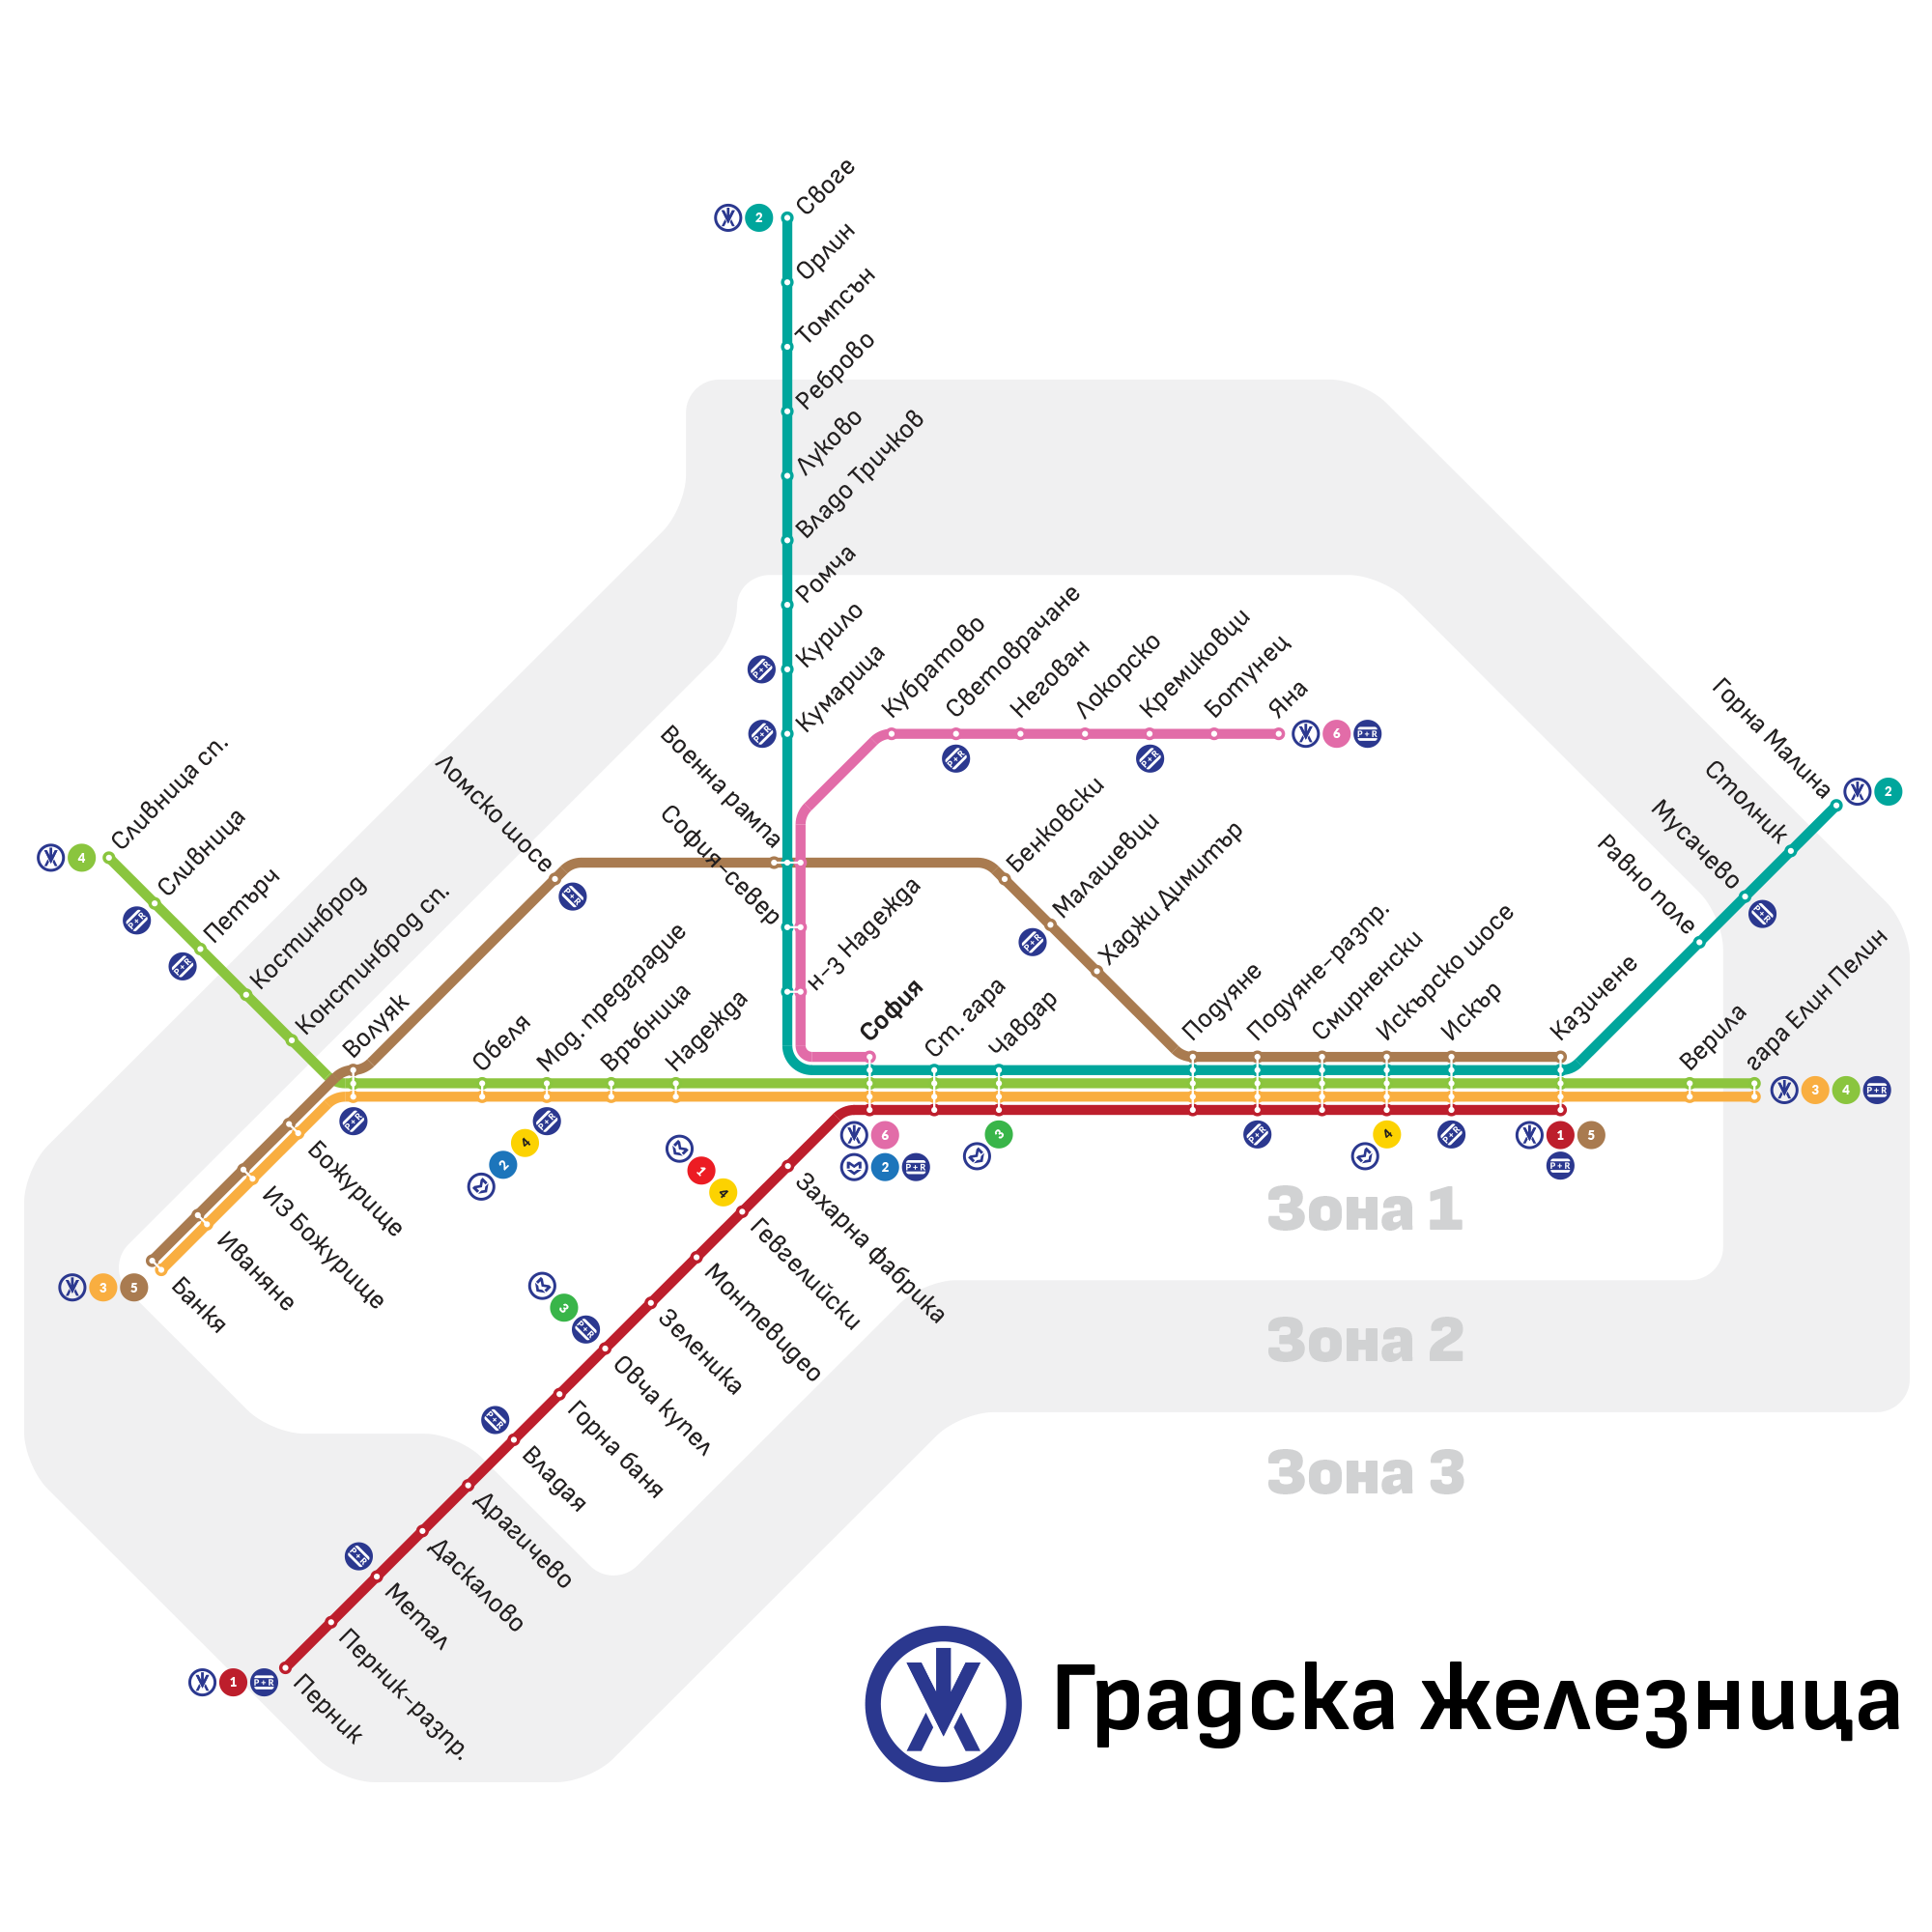


### Part 1: Definition of the proposed lines

#### 1.1 Lines

The project will discuss the followin proposed lines:
   - Перник – Централна жп гара – Казичене #с интервал на движение от 30 минути;
   - Своге – Централна жп гара – Казичене – Ботунец #с интервал на движение от 60 минути;
   - Банкя – Централна жп гара – гара Елин Пелин #с интервал на движение от 30 минути.
   - Сливница – гара Елин Пелин #с интервал на движение от 30 минути;
   - Банкя – Биримирци – гара Подуяне – Казичене #с интервал на движение от 30 минути;
   - Рингова линия Яна – Централна жп гара – Яна #с интервал на движение от 30 минути.
   
   
Further in this project the lines may be called Line N:1, 2, etc., respectively.

#### 1.2 Stops

In [3]:
line1_stops = ["Перник", "Перник разпределителна", "Метал", "Даскалово", "Драгичево", "Владая", "Горна Баня", 
               "Овча Купел", "Зеленика", "Ментевидео", "Гевгелийски", "Захарна фабрика",
               "София", "Сточна гара", "Чавдар", "Подуяне", "Подуяне разпределителна", "Смирненски", "Искърско шосе",
               "Искър", "Казичене"]

line2_stops = ["Своге", "Орлин", "Томпсън", "Реброво", "Луково", "Владо Тричков", "Ромча", 
               "Курило", "Кумарица", "Военна рампа", "София север", "Надлез Haдeждa",
               "София", "Сточна гара", "Чавдар", "Подуяне", "Подуяне разпределителна", "Смирненски", "Искърско шoce",
               "Искър", "Казичене", "Равно поле", "Мусачево", "Столник", "Горна Малина"]


line3_stops = ["Банкя", "Иваняне", "ИЗ Божурище", "Божурище", "Волуяк", "Обеля", "Moд. предградие", 
               "Връбница", "Надежда", "София", "Сточна гара", "Чавдар", "Подуяне", "Подуяне разпределителна", "Смирненски", "Искърско шoce",
               "Искър", "Казичене", "Верила", "Елин Пелин"]
            
line4_stops = ["Сливница спирка", "Сливница", "Петърч", "Костинброд", "Констинброд спирка", "Волуяк", "Обеля", "Мод. предградие", 
               "Връбница", "Надежда", "София", "Сточна гара", "Чавдар", "Подуяне", "Подуяне разпределителна", "Смирненски", "Искърско шoce",
               "Искър", "Казичене", "Верила", "Елин Пелин"]            
            
            
            
            
line5_stops = ["Банкя", "Иваняне", "ИЗ Божурище", "Божурище", "Волуяк", "Ломско шосе", "Военна рампа", 
               "Бенковски", "Малашевци", ". Хаджи Димитър", "Подуяне", "Подуяне разпределителна", "Смирненски", "Искърско шoce",
               "Искър", "Казичене"]
        
line6_stops = ["София", "Hадлез Haдeждa", "София север", "Военна рампа", "Кубратово", "Световрачане", "Негован", 
               "Локорско", "Кремиковци", "Ботунец", "Яна"]


all_proposed_stops = line1_stops + line2_stops + line3_stops + line4_stops + line5_stops + line6_stops


### Part 2: Analysis of the current travel options

#### 2.1 Comparison between current travel times by different modes

For each of the lines we will start by comparing current existing modes of transportation by their travel times and CO2 emissions.

Let's start by defining a list of the proposed routes:

In [4]:
proposed_lines = [
    "Перник – Централна жп гара – Казичене",
    "Своге – Централна жп гара – Казичене – Ботунец",
    "Банкя – Централна жп гара – гара Елин Пелин",
    "Сливница – гара Елин Пелин",
    "Банкя – Биримирци – гара Подуяне – Казичене",
    "Рингова линия Яна – Централна жп гара – Яна"]


We need to load the dataset containing the mean transport times by car, public transport and rail.

In [5]:
xlsx_path = 'data/transport_times_target_stations.xlsx'
transport_times = pd.read_excel(xlsx_path)

new_column_names = ['Proposed_Line', 'Car journey in min', 'Rail journey in min', 'Public transit journey in min']
transport_times.columns = new_column_names
transport_times = transport_times.iloc[1:]


time_columns = ['Car journey in min', 'Rail journey in min', 'Public transit journey in min']
transport_times[time_columns] = transport_times[time_columns].apply(pd.to_numeric, errors='coerce')


transport_times

,Proposed_Line,Car journey in min,Rail journey in min,Public transit journey in min
1,Перник – Централна жп гара – Казичене,64,103,NaN
2,Своге – Централна жп гара – Казичене – Ботунец,99,106,NaN
3,Банкя – Централна жп гара – гара Елин Пелин,63,112,NaN
4,Сливница – гара Елин Пелин,50,100,NaN
5,Банкя – Биримирци – гара Подуяне – Казичене,62,80,NaN
6,Рингова линия Яна – Централна жп гара – Яна,48,296,NaN


So, at this point we can see that there are no existing public transit options between the endpoints in the proposed lines. We will remember to add this comparison to each line, but we are going to remove the "Public transit journey in min" column from the dataset.

In [6]:
transport_times = transport_times.drop(['Public transit journey in min'], axis = 1)

After we have prepared the first dataset we will lopp through it and check the faster mode of transportation and the time difference for each line 

In [7]:
proposed_lines = transport_times['Proposed_Line'].unique()

for line in proposed_lines:
    line_data = transport_times[transport_times['Proposed_Line'] == line]
    
    car_time = line_data['Car journey in min'].values[0]
    rail_time = line_data['Rail journey in min'].values[0]
    
    if car_time < rail_time:
        faster_mode = "Car"
        time_difference = rail_time - car_time
    else:
        faster_mode = "Rail"
        time_difference = car_time - rail_time
    
    print(f"For line: {line}")
    print(f"Faster mode: {faster_mode}")
    print(f"Time difference: {time_difference} minutes\n")

For line: Перник – Централна жп гара – Казичене
Faster mode: Car
Time difference: 39 minutes

For line: Своге – Централна жп гара – Казичене – Ботунец
Faster mode: Car
Time difference: 7 minutes

For line: Банкя – Централна жп гара – гара Елин Пелин
Faster mode: Car
Time difference: 49 minutes

For line: Сливница – гара Елин Пелин
Faster mode: Car
Time difference: 50 minutes

For line: Банкя – Биримирци – гара Подуяне – Казичене 
Faster mode: Car
Time difference: 18 minutes

For line: Рингова линия Яна – Централна жп гара – Яна
Faster mode: Car
Time difference: 248 minutes



Here, we can already see that for each of the proposed lines the current faster mode of transportation is the car and on most of the routes the difference is more than 15 minutes. We can also show this visually.

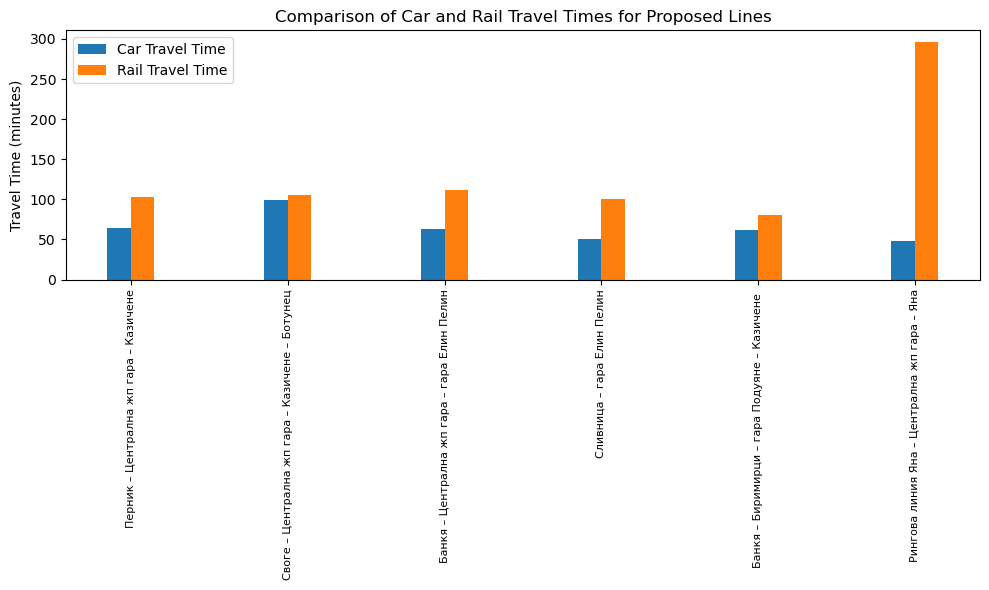

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = range(len(proposed_lines))

car_times = []
rail_times = []

for line in proposed_lines:
    line_data = transport_times[transport_times['Proposed_Line'] == line]
    
    car_time = line_data['Car journey in min'].values[0]
    rail_time = line_data['Rail journey in min'].values[0]
    
    car_times.append(car_time)
    rail_times.append(rail_time)

bar1 = ax.bar(index, car_times, bar_width, label='Car Travel Time')
bar2 = ax.bar([i + bar_width for i in index], rail_times, bar_width, label='Rail Travel Time')

ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(proposed_lines, rotation='vertical', fontsize=8)

ax.set_ylabel('Travel Time (minutes)')
ax.set_title('Comparison of Car and Rail Travel Times for Proposed Lines')
ax.legend()

plt.tight_layout()
plt.show()

#### 2.2 Comparison between harmful emissions released between modes

We wanna compare the emissions on those routes between the rail and car traffic. The data is sourced from Eco Passenger: [https://ecopassenger.hafas.de/bin/query.exe/en?L=vs_uic&newrequest=yes&] 

We will loop-load the needed files and take the data that we need after a short preparation.

In [9]:
file_names = ['1pernik_kazichene.xlsx', '2svoge_botunets.xlsx', '3bankya_elin_pelin.xlsx', '4slivnitsa_elin_pelin.xlsx', '5bankya_kazichene.xlsx', '6yana_sofia.xlsx']

new_column_names = {'COMPONENT \r': 'Component', 'TRAIN \r': 'Train', 'CAR \r': 'Car'}

prepared_dataframes = []

for file_name in file_names:
    file_path = os.path.join('data', file_name)
    
    data = pd.read_excel(file_path)
    
    data.rename(columns=new_column_names, inplace=True)
    
    data = data.replace({'\r': ''}, regex=True)
    
    prepared_dataframes.append(data)

for idx, df in enumerate(prepared_dataframes, start=1):
    print(f"Line N: {idx}:\n{df}\n") 


Line N: 1:
                                           Component  Train    Car
0                          Carbon dioxide kilograms    3,1    5,5 
1  Energy resource consumption liter gasoline equ...   1,6    2,5 
2                          Particulate matter grams   0,93   0,54 
3                             Nitrogen oxides grams    3,3   22,9 
4                     Nonmethane hydrocarbons grams   0,11    1,9 

Line N: 2:
                                           Component  Train    Car
0                          Carbon dioxide kilograms    2,4    4,5 
1  Energy resource consumption liter gasoline equ...   1,3    2,0 
2                          Particulate matter grams   0,73   0,44 
3                             Nitrogen oxides grams    2,6   18,5 
4                     Nonmethane hydrocarbons grams   0,08    1,5 

Line N: 3:
                                           Component  Train    Car
0                          Carbon dioxide kilograms    2,5    4,8 
1  Energy resource consumpt

After we have printed the new list with dataframes, we can see that some specific rows actually indicate consumption and not emission. We will separate those from the main dataframes.

In [10]:
prepared_dataframes = []

for file_name in file_names:
    file_path = os.path.join('data', file_name)
    
    data = pd.read_excel(file_path)
    
    data.rename(columns=new_column_names, inplace=True)
    
    data = data.replace({'\r': ''}, regex=True)
    
    prepared_dataframes.append(data)

specific_rows = []

for idx, df in enumerate(prepared_dataframes, start=1):
    specific_row = df[df['Component'] == 'Energy resource consumption liter gasoline equivalent ']  
    specific_rows.append(specific_row)

    prepared_dataframes[idx-1] = df.drop(specific_row.index)

specific_df = pd.concat(specific_rows, ignore_index=True)

print("DataFrame with Energy Values:")
print(specific_df)

for idx, df in enumerate(prepared_dataframes, start=1):
    print(f"Modified Line N: {idx}:\n{df}\n")


DataFrame with Energy Values:
                                           Component Train   Car
0  Energy resource consumption liter gasoline equ...  1,6   2,5 
1  Energy resource consumption liter gasoline equ...  1,3   2,0 
2  Energy resource consumption liter gasoline equ...  1,2   2,2 
3  Energy resource consumption liter gasoline equ...  1,6   3,1 
4  Energy resource consumption liter gasoline equ...  1,1   1,8 
5  Energy resource consumption liter gasoline equ...  1,0   1,3 
Modified Line N: 1:
                        Component  Train    Car
0       Carbon dioxide kilograms    3,1    5,5 
2       Particulate matter grams   0,93   0,54 
3          Nitrogen oxides grams    3,3   22,9 
4  Nonmethane hydrocarbons grams   0,11    1,9 

Modified Line N: 2:
                        Component  Train    Car
0       Carbon dioxide kilograms    2,4    4,5 
2       Particulate matter grams   0,73   0,44 
3          Nitrogen oxides grams    2,6   18,5 
4  Nonmethane hydrocarbons grams   0,08   

Now that we have separated the energy values, we can see the difference in percentage by emissions and mode of transportation.

In [11]:
percentage_differences = []

for idx, df in enumerate(prepared_dataframes, start=1):
    print(f"Line N: {idx}:\n")
    

    train_emissions = float(df.loc[0, 'Train'].replace(',', '.'))
    car_emissions = float(df.loc[0, 'Car'].replace(',', '.'))

    gas_components = df['Component']
    
    for gas in gas_components:
        train_gas_emissions = float(df.loc[df['Component'] == gas, 'Train'].values[0].replace(',', '.'))
        car_gas_emissions = float(df.loc[df['Component'] == gas, 'Car'].values[0].replace(',', '.'))
        
        gas_emissions_difference = car_gas_emissions - train_gas_emissions
        percentage_difference = (gas_emissions_difference / train_gas_emissions) * 100
        
        percentage_differences.append(percentage_difference)
        
        print(f"{gas}:")
        print(f"Train emits: {train_gas_emissions:.2f} kg")
        print(f"Car emits: {car_gas_emissions:.2f} kg")
        print(f"Percentage difference: {percentage_difference:.2f}%")
        print("=" * 40)

# print("List of Percentage Differences:", percentage_differences)


Line N: 1:

Carbon dioxide kilograms :
Train emits: 3.10 kg
Car emits: 5.50 kg
Percentage difference: 77.42%
Particulate matter grams :
Train emits: 0.93 kg
Car emits: 0.54 kg
Percentage difference: -41.94%
Nitrogen oxides grams :
Train emits: 3.30 kg
Car emits: 22.90 kg
Percentage difference: 593.94%
Nonmethane hydrocarbons grams :
Train emits: 0.11 kg
Car emits: 1.90 kg
Percentage difference: 1627.27%
Line N: 2:

Carbon dioxide kilograms :
Train emits: 2.40 kg
Car emits: 4.50 kg
Percentage difference: 87.50%
Particulate matter grams :
Train emits: 0.73 kg
Car emits: 0.44 kg
Percentage difference: -39.73%
Nitrogen oxides grams :
Train emits: 2.60 kg
Car emits: 18.50 kg
Percentage difference: 611.54%
Nonmethane hydrocarbons grams :
Train emits: 0.08 kg
Car emits: 1.50 kg
Percentage difference: 1775.00%
Line N: 3:

Carbon dioxide kilograms :
Train emits: 2.50 kg
Car emits: 4.80 kg
Percentage difference: 92.00%
Particulate matter grams :
Train emits: 0.65 kg
Car emits: 0.48 kg
Percentage

We will prepare this data by renaming the gasses and adding two new columns with relevant infromation.

In [12]:
percentage_differences = []

gas_name_mapping = {
    'Carbon dioxide kilograms ': 'CO2',
    'Particulate matter grams ': 'Particulate Matter',
    'Nitrogen oxides grams ': 'NOx',
    'Nonmethane hydrocarbons grams ': 'NMHC'
}

for idx, df in enumerate(prepared_dataframes, start=1):
    gas_components = df['Component']
    
    for gas in gas_components:
        train_gas_emissions = float(df.loc[df['Component'] == gas, 'Train'].values[0].replace(',', '.'))
        car_gas_emissions = float(df.loc[df['Component'] == gas, 'Car'].values[0].replace(',', '.'))
        
        gas_emissions_difference = car_gas_emissions - train_gas_emissions
        percentage_difference = (gas_emissions_difference / train_gas_emissions) * 100
        
        higher_emitter = 'Car' if car_gas_emissions > train_gas_emissions else 'Train'
        
        new_gas_name = gas_name_mapping.get(gas, gas)
        
        formatted_percentage = f"{percentage_difference:.2f}%"
        
        percentage_differences.append({
            'Gas': new_gas_name,
            'Percentage_Difference': formatted_percentage,
            'Higher_Emitter': higher_emitter
        })

df_tabular = pd.DataFrame(percentage_differences)

df_tabular


,Gas,Percentage_Difference,Higher_Emitter
0,CO2,77.42%,Car
1,Particulate Matter,-41.94%,Train
2,NOx,593.94%,Car
3,NMHC,1627.27%,Car
4,CO2,87.50%,Car
5,Particulate Matter,-39.73%,Train
6,NOx,611.54%,Car
7,NMHC,1775.00%,Car
8,CO2,92.00%,Car
9,Particulate Matter,-26.15%,Train


Plotting this will show us which mode of transportation is the higher emitter overall.

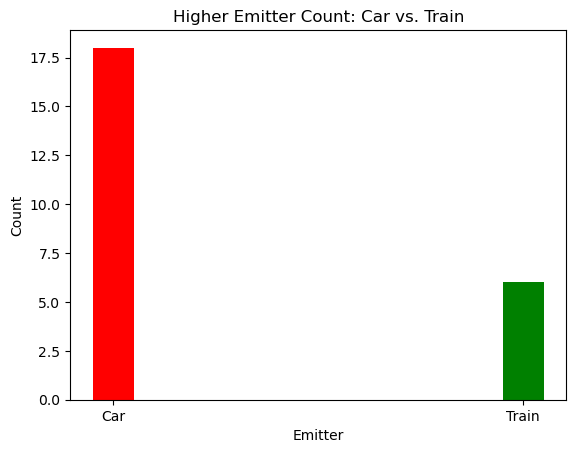

In [13]:
higher_emitter_counts = df_tabular['Higher_Emitter'].value_counts()

bar_width = 0.1

plt.bar(higher_emitter_counts.index, higher_emitter_counts.values, width=bar_width, color=['red', 'green'])

plt.xlabel('Emitter')
plt.ylabel('Count')
plt.title('Higher Emitter Count: Car vs. Train')

plt.show()


#### 2.3 Comparission between energy consumption

In [14]:
specific_df

,Component,Train,Car
0,Energy resource consumption liter gasoline equ...,"1,6","2,5"
1,Energy resource consumption liter gasoline equ...,"1,3","2,0"
2,Energy resource consumption liter gasoline equ...,"1,2","2,2"
3,Energy resource consumption liter gasoline equ...,"1,6","3,1"
4,Energy resource consumption liter gasoline equ...,"1,1","1,8"
5,Energy resource consumption liter gasoline equ...,"1,0","1,3"


In [15]:
specific_df['Component'] = ['Line N: ' + str(i) for i in range(1, len(specific_df) + 1)]

specific_df['Train'] = specific_df['Train'].str.replace(',', '.').astype(float)
specific_df['Car'] = specific_df['Car'].str.replace(',', '.').astype(float)

specific_df['Higher_Consumer'] = specific_df.apply(lambda row: 'Car' if row['Car'] > row['Train'] else 'Train', axis=1)

specific_df.drop(['Train', 'Car'], axis=1, inplace=True)

specific_df


,Component,Higher_Consumer
0,Line N: 1,Car
1,Line N: 2,Car
2,Line N: 3,Car
3,Line N: 4,Car
4,Line N: 5,Car
5,Line N: 6,Car


We can see above that the Car is the higher consumer of energy compared to the train on all of the routes.

### Part 3: Existing infrastructure

#### 3.1 Checking for existing train stations along the proposed routes

In this part we will check the existing infrastructure along the proposed lines. For this we will load data and clear it.

In [16]:
rail_stops_response = requests.get("https://api.sofiaplan.bg/datasets/602")
rail_stops = rail_stops_response.json()['features']

rail_stops_df = gpd.GeoDataFrame.from_features(rail_stops)
rail_stops_df.head()

,geometry,id,tradename,2016_prist,2016_zamin,2019_zamin,2019_prist
0,MULTIPOINT (23.18526 42.62333),1,гара Владая,NaN,NaN,NaN,NaN
1,MULTIPOINT (23.32096 42.71204),2,Централна гара София,2441210.0,2022834.0,2081353.0,2388925.0
2,MULTIPOINT (23.41287 42.66446),3,гара Искър,149943.0,116639.0,104963.0,133145.0
3,MULTIPOINT (23.35474 42.69788),4,гара Подуяне,44001.0,120367.0,101771.0,45376.0
4,MULTIPOINT (23.31649 42.72660),5,гара София Север,47284.0,92555.0,119478.0,37287.0


We will split this into two dataframes and use the data about passengers later on.

In [17]:
rail_stops_info_df = rail_stops_df[['geometry', 'id', 'tradename']]

passengers_per_station_df = rail_stops_df[['tradename', '2016_prist', '2016_zamin', '2019_zamin', '2019_prist']]

Now we have a dataframe with the coordinates and names of each station and we can confirm that there are 28 stations already in existence.

In [18]:
rail_stops_info_df.shape

(28, 3)

We wanna check if the proposed stops aleady exist by comparing the list we created in the beginning to the dataframe above.

In [19]:
all_proposed_stops_df = pd.DataFrame(all_proposed_stops, columns=['Proposed_Stop'])


unique_proposed_stops = all_proposed_stops_df['Proposed_Stop'].unique()
unique_proposed_stops_df = pd.DataFrame({'Unique_Proposed_Stop': unique_proposed_stops})

num_unique = len(unique_proposed_stops)
print("Num unique stops:", num_unique)

Num unique stops: 67


Based on the data we have at hand we can cofnirm that 28 out of the 67 stations on the proposed lines already exist/are in operation.

We can visualize the location of the confirmed maps: 

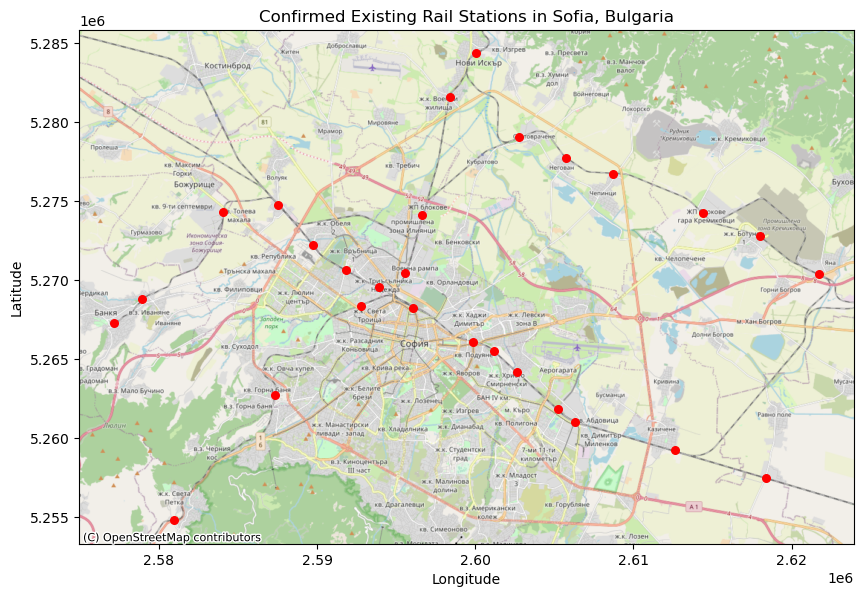

In [20]:
stops_gdf = rail_stops_info_df.copy()
stops_gdf = gpd.GeoDataFrame(stops_gdf, geometry='geometry')

stops_gdf.crs = 'EPSG:4326'

fig, ax = plt.subplots(figsize=(10, 10))

basemap = ctx.providers.OpenStreetMap.Mapnik

# Convert the CRS to EPSG:3857 (Web Mercator)
stops_gdf = stops_gdf.to_crs(epsg=3857)

ax = stops_gdf.plot(ax=ax, marker='o', color='red', markersize=30)

ctx.add_basemap(ax, source=basemap)

plt.title('Confirmed Existing Rail Stations in Sofia, Bulgaria')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

Further data is needed to check for the existence of further stops.

### Part 4: Analyzing key factors

#### 4.1 Historical Ridership Data

For this part we will use the data we have about the yearly ridership per station.

In [21]:
passengers_per_station_df_copy = passengers_per_station_df.copy()

passengers_per_station_df_copy['2016_total'] = passengers_per_station_df_copy['2016_prist'] + passengers_per_station_df_copy['2016_zamin']
passengers_per_station_df_copy['2019_total'] = passengers_per_station_df_copy['2019_prist'] + passengers_per_station_df_copy['2019_zamin']
passengers_per_station_df_copy['difference'] = passengers_per_station_df_copy['2019_total'] - passengers_per_station_df_copy['2016_total']


passengers_per_station_df_copy.drop(['2016_prist', '2016_zamin', '2019_prist', '2019_zamin'], axis=1, inplace=True)
passengers_per_station_df_copy.dropna(inplace=True)

In [22]:
passengers_per_station_df_copy

,tradename,2016_total,2019_total,difference
1,Централна гара София,4464044.0,4470278.0,6234.0
2,гара Искър,266582.0,238108.0,-28474.0
3,гара Подуяне,164368.0,147147.0,-17221.0
4,гара София Север,139839.0,156765.0,16926.0
5,гара Захарна фабрика,246598.0,186368.0,-60230.0
6,гара Банкя,34617.0,43372.0,8755.0
7,гара Горна Баня,246367.0,205483.0,-40884.0
8,гара Волуяк,13352.0,15326.0,1974.0
12,спирка Иваняне,1567.0,1893.0,326.0
15,спирка Обеля,7554.0,4801.0,-2753.0


In [23]:
passengers_per_station_df_copy.sort_values(by='difference', inplace=True)


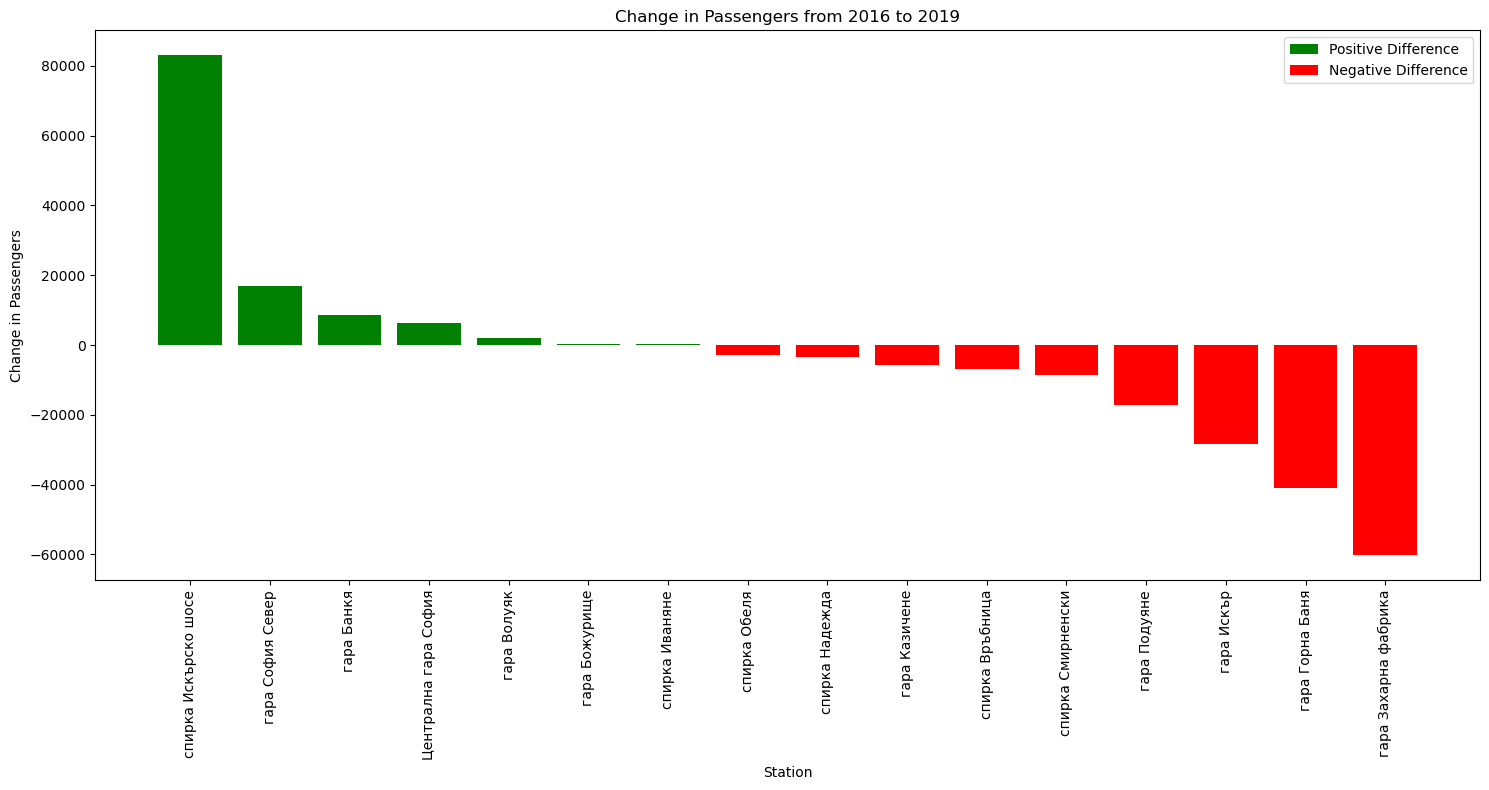

In [38]:
#should show the bar chart by station gained the most passengers and then descend, \n
#however sometimes upon restarting the kernel it messes up the order. Re-running this cell should order it correctly.

plt.figure(figsize=(15, 8))
ax = plt.subplot()

colors = ['green' if diff >= 0 else 'red' for diff in passengers_per_station_df_copy['difference']]
passengers_per_station_df_copy = passengers_per_station_df_copy.sort_values(by='difference', ascending=False)


bar_width = 0.8

bars = ax.bar(passengers_per_station_df_copy['tradename'], passengers_per_station_df_copy['difference'], color=colors, width=bar_width)

plt.xlabel('Station')
plt.ylabel('Change in Passengers')
plt.title('Change in Passengers from 2016 to 2019')
plt.xticks(rotation=90)
ax.legend(handles=[bars[0], bars[-1]], labels=['Positive Difference', 'Negative Difference'], loc='upper right')

plt.tight_layout()
plt.show()

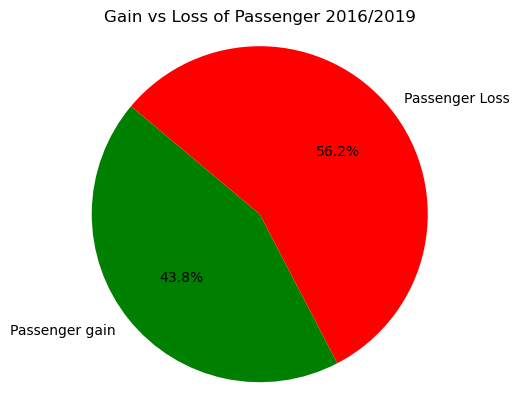

In [25]:
positive_count = (passengers_per_station_df_copy['difference'] >= 0).sum()
negative_count = (passengers_per_station_df_copy['difference'] < 0).sum()

# Create a pie chart
labels = ['Passenger gain', 'Passenger Loss']
sizes = [positive_count, negative_count]
colors = ['green', 'red']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Gain vs Loss of Passenger 2016/2019')
plt.show()

We confirmed that most of the lines that we have data about lost passengers in 2019 compared to 2016.

#### 4.2 Population

We will start by creating a list of cities and towns that include the proposed stations and are in the Sofia agglomeration, but not in the city itself. We might use this to be able to check further datasets.

In [26]:
city_list = ['Перник', 'Драгичево', 'Владая', 'Казичене', 'Своге', 'Томпсън', 'Реброво',
            'Луково', 'Владо Тричков', 'Нови Искър', 'Равно поле', 'Мусачево', 'Столник',
            'Горна Малина', 'Банкя', 'Иваняне', 'Божурище', 'Волуяк', 'Петърч', 
             'Костинброд', 'Кубратово', 'Световрачане', 'Негован', 'Локорско',
             'Кремиковци', 'Ботунец', 'Яна', 'София']

Preparing the next dataset, which will look at the population in the abovementioned cities.

We will define a function which will search through the data and extract only the information that we will need. The output will be a cleaner version of what we need.

In [27]:
def extract_rows_by_keywords(dataframe, keywords, rows_to_extract):
    processed_data = []
    current_city = None
    rows_extracted = 0

    for index, row in dataframe.iterrows():
        location_age = row['Location/Age']
        number_of_people = row['Number of People']

        if location_age in keywords:
            current_city = location_age
            rows_extracted = 0
        elif current_city is not None and rows_extracted < rows_to_extract:
            processed_data.append({'City': current_city, 'Age Range': location_age, 'Number of People': number_of_people})
            rows_extracted += 1

    processed_data_df = pd.DataFrame(processed_data)
    return processed_data_df

sheet_name = '2022'
population_df = pd.read_excel('data/Pop_6.1.3_Pop_DR.xls', sheet_name=sheet_name)

population_df_cleaned = population_df.dropna().rename(columns={'Unnamed: 0': 'Location/Age', 'Unnamed: 1': 'Number of People'})

keywords = ['Перник', 'София', 'София (столица)']
rows_to_extract = 22

extracted_df = extract_rows_by_keywords(population_df_cleaned, keywords, rows_to_extract)

extracted_df

,City,Age Range,Number of People
0,Перник,0,791
1,Перник,1 - 4,3655
2,Перник,5 - 9,4893
3,Перник,10 - 14,5339
4,Перник,15 - 19,4653
...,...,...,...
61,София (столица),80 - 84,29482
62,София (столица),85 - 89,17568
63,София (столица),90 - 94,6656
64,София (столица),95 - 99,1262


For the purpose of this project we will define an "active group" of the populatio and namely people between 15 and 64 years. The population from this group is more likely to travel and this will help our project.

In [28]:
age_ranges = extracted_df['Age Range'].str.extract(r'(\d+)\s*-\s*(\d+)')

# Convert extracted age ranges to numeric values
age_ranges = age_ranges.apply(pd.to_numeric, errors='coerce')

age_15_64_rows = extracted_df[(age_ranges[0] >= 15) & (age_ranges[1] <= 64)]

city_population_active = age_15_64_rows.groupby('City')['Number of People'].sum().reset_index()

city_population_active

,City,Number of People
0,Перник,68305
1,София,140948
2,София (столица),845799


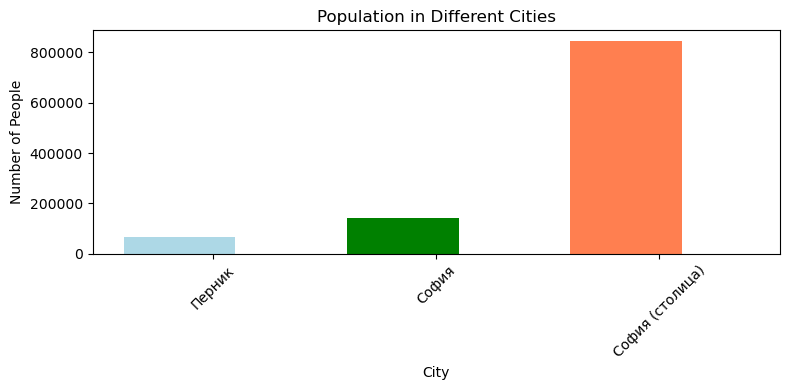

In [29]:
plt.figure(figsize=(8, 4))  # Adjust the figure size (width, height)

# Customize the colors of the bars
bar_colors = ['lightblue', 'green', 'coral']

# Create the bar plot
bars = plt.bar(city_population_active['City'], city_population_active['Number of People'], color=bar_colors)

# Customize other plot elements
plt.xlabel('City')
plt.ylabel('Number of People')
plt.title('Population in Different Cities')
plt.xticks(rotation=45)  # Rotate city names for better readability
plt.tight_layout()

for bar in bars:
     bar.set_width(0.5)  # Adjust the width as needed

plt.show()

#### 4.3 Economic factors

Starting with a function that will drop unneed columns, renamed the remaining ones and then filter the dataframe to extraxt information on GDP just for the needed Regions.

In [30]:
def clean_gdp_data(file_path, sheet_name, keywords):
    gdp_data = pd.read_excel(file_path, sheet_name=sheet_name)

    columns_to_keep = ['Unnamed: 3', 'Unnamed: 8', 'Unnamed: 9']
    gdp_data = gdp_data[columns_to_keep]

    new_column_names = ['City', 'GDP in mil BGN', 'GDP per capita BGN']
    gdp_data.columns = new_column_names

    gdp_data = gdp_data.iloc[6:]

    gdp_data.reset_index(drop=True, inplace=True)

    gdp_data_filtered = gdp_data[gdp_data['City'].isin(keywords)]

    return gdp_data_filtered

file_path = 'data/GDP_1.1.4.xls'
sheet_name = '2021'
keywords = ['Перник', 'София', 'София (столица)']
cleaned_gdp_data = clean_gdp_data(file_path, sheet_name, keywords)

cleaned_gdp_data


,City,GDP in mil BGN,GDP per capita BGN
25,Перник,1321.498,11084.117
26,София,4546.885,19263.076
27,София (столица),59171.621,45240.819


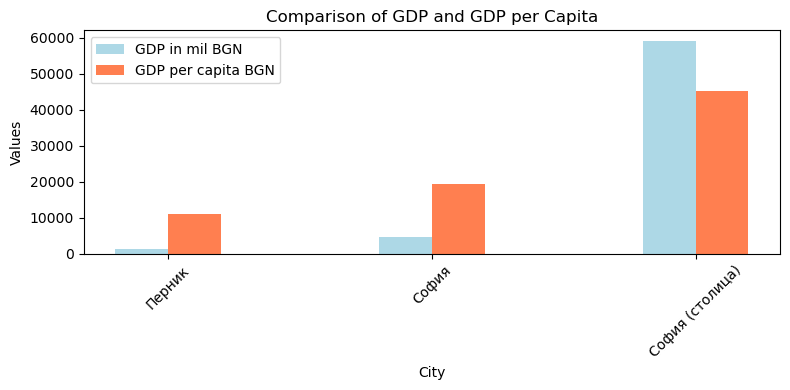

In [31]:
plt.figure(figsize=(8, 4))

bar_width = 0.2
index = range(len(cleaned_gdp_data))

plt.bar(index, cleaned_gdp_data['GDP in mil BGN'], width=bar_width, label='GDP in mil BGN', color='lightblue')
plt.bar([i + bar_width for i in index], cleaned_gdp_data['GDP per capita BGN'], width=bar_width, label='GDP per capita BGN', color='coral')

plt.xlabel('City')
plt.ylabel('Values')
plt.title('Comparison of GDP and GDP per Capita')
plt.xticks([i + bar_width/2 for i in index], cleaned_gdp_data['City'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

#### 4.4 Unemployment rates

Let's check some data about the unemployemnt in the minicipalities we've been discussing until now.

In [32]:
xlsx_file = 'data/Labour_3.2.3.xls'
sheet_name = '2022'
employment_df = pd.read_excel(xlsx_file, sheet_name=sheet_name)

employment_df = employment_df[['Unnamed: 0', 'Unnamed: 3', 'Unnamed: 4']]
employment_df.columns = ['City', 'Thousand unemployed', 'Unemployment rate']

employment_rate = employment_df.loc[148:150]
employment_rate

,City,Thousand unemployed,Unemployment rate
148,Перник,6.5,11.3
149,София,1.1,1
150,София (столица),17.5,2.5


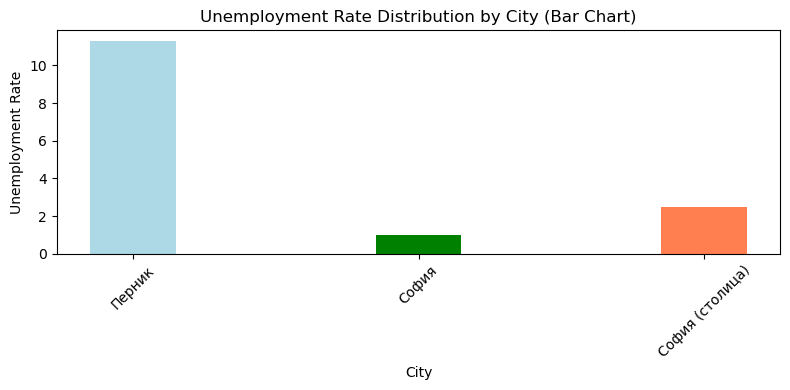

In [33]:
bar_colors = ['lightblue', 'green', 'coral']
bar_width = 0.3 

plt.figure(figsize=(8, 4))

plt.bar(employment_rate['City'], employment_rate['Unemployment rate'], color=bar_colors, width=bar_width)
plt.xlabel('City')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate Distribution by City (Bar Chart)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### 5. Ridership forecast

Start by combining all the relevant data in a single dataframe.

In [34]:
merged_data = pd.merge(city_population_active, cleaned_gdp_data, on='City')
merged_data = pd.merge(merged_data, employment_rate, on='City')
columns_to_convert = ['GDP in mil BGN', 'GDP per capita BGN', 'Thousand unemployed', 'Unemployment rate']

for column in columns_to_convert:
    merged_data[column] = pd.to_numeric(merged_data[column], errors='coerce')
merged_data

,City,Number of People,GDP in mil BGN,GDP per capita BGN,Thousand unemployed,Unemployment rate
0,Перник,68305,1321.498,11084.117,6.5,11.3
1,София,140948,4546.885,19263.076,1.1,1.0
2,София (столица),845799,59171.621,45240.819,17.5,2.5


Then we will go back to a dataframe we stored earlier in this project. It shows the ridership per station in year 2016 and in year 2019. The data is not full eg. it has info about only 16 of the proposed stations.

Creating a function to seperate the values of this dataframe (passengers_per_station_df_copy) into 3 arbitrary categories named after the cities/regions where the proposed stations should be. Each of the cities will contain a sum of a third of the dataset. 

In [35]:
def combine_rows_and_sum(df):
    # Calculate the number of rows per group
    num_rows_per_group = len(df) // 3

    sum_group1 = df.iloc[:num_rows_per_group, 1:].sum()
    sum_group2 = df.iloc[num_rows_per_group: 2*num_rows_per_group, 1:].sum()
    sum_group3 = df.iloc[2*num_rows_per_group:, 1:].sum()

    combined_df = pd.DataFrame({
        df.columns[0]: ['София', 'София (столица)', 'Перник'],
        df.columns[1]: [sum_group1[0], sum_group2[0], sum_group3[0]],
        df.columns[2]: [sum_group1[1], sum_group2[1], sum_group3[1]],
        df.columns[3]: [sum_group1[2], sum_group2[2], sum_group3[2]]
    })

    return combined_df

combined_df = combine_rows_and_sum(passengers_per_station_df_copy)
combined_df

,tradename,2016_total,2019_total,difference
0,София,4701453.0,4818374.0,116921.0
1,София (столица),45824.0,34626.0,-11198.0
2,Перник,962393.0,800086.0,-162307.0


Check stationarity of the time series and make them stationary.

p-value for 2016_total: 0.9803584937740338
p-value for 2019_total: 0.9735111054243268


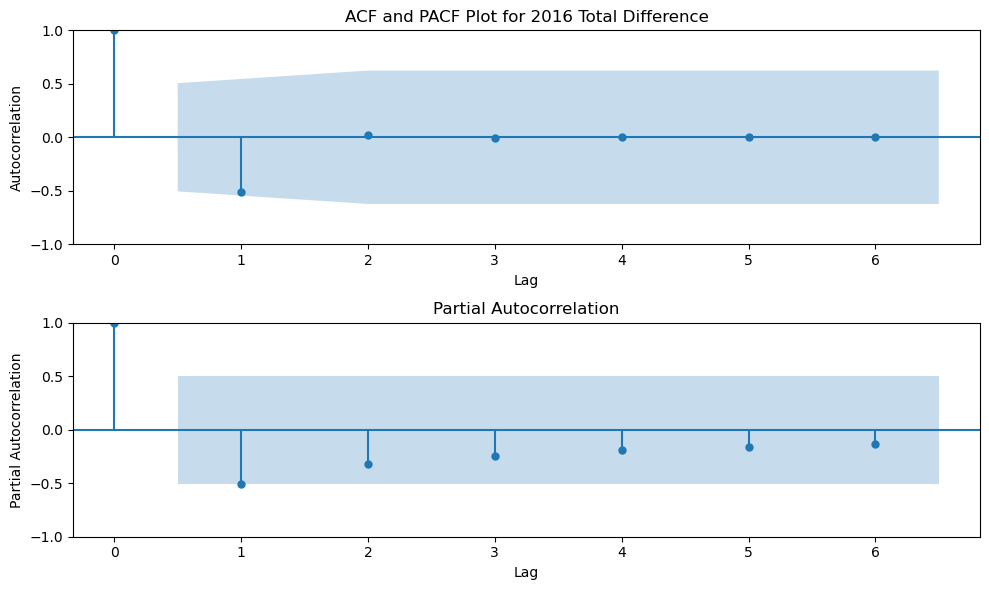

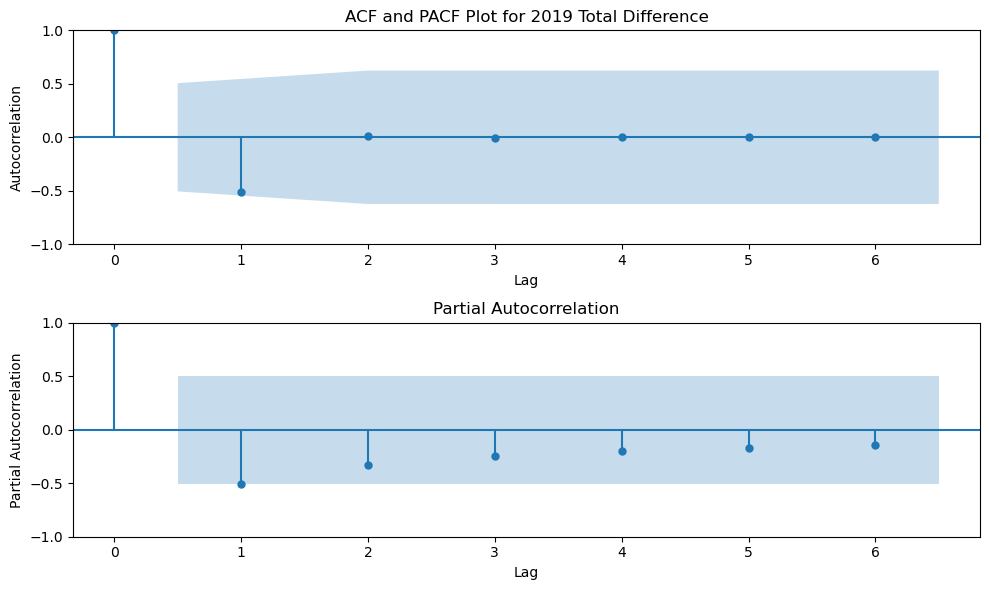

In [36]:
def check_stationarity(data):
    result = adfuller(data)
    p_value = result[1]
    return p_value

p_value_2016 = check_stationarity(passengers_per_station_df_copy['2016_total'])
p_value_2019 = check_stationarity(passengers_per_station_df_copy['2019_total'])
print("p-value for 2016_total:", p_value_2016)
print("p-value for 2019_total:", p_value_2019)


# Apply differencing to make the data stationary
passengers_per_station_df_copy['2016_total_diff'] = passengers_per_station_df_copy['2016_total'] - passengers_per_station_df_copy['2016_total'].shift(1)
passengers_per_station_df_copy['2019_total_diff'] = passengers_per_station_df_copy['2019_total'] - passengers_per_station_df_copy['2019_total'].shift(1)




def plot_acf_pacf(data, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(data, lags=6, ax=ax1)
    ax1.set_title(f"ACF and PACF Plot for {title}")
    ax1.set_xlabel("Lag")
    ax1.set_ylabel("Autocorrelation")

    plot_pacf(data, lags=6, ax=ax2)
    ax2.set_xlabel("Lag")
    ax2.set_ylabel("Partial Autocorrelation")

    plt.tight_layout()
    plt.show()

plot_acf_pacf(passengers_per_station_df_copy['2016_total_diff'].dropna(), title="2016 Total Difference")
plot_acf_pacf(passengers_per_station_df_copy['2019_total_diff'].dropna(), title="2019 Total Difference")

In [37]:
time_series_data = combined_df

# Perform auto ARIMA forecasting for '2016_total'
model_2016 = auto_arima(time_series_data['2016_total'], seasonal=False, trace=True)
p_2016, d_2016, q_2016 = model_2016.order

# Fit the ARIMA model for '2016_total'
arima_model_2016 = ARIMA(time_series_data['2016_total'], order=(p_2016, d_2016, q_2016))
arima_fit_2016 = arima_model_2016.fit()

# Make forecasts for '2016_total'
forecast_steps = 5 
forecast_2016 = arima_fit_2016.forecast(steps=forecast_steps)

print("Optimal ARIMA Order for 2016_total:", (p_2016, d_2016, q_2016))
print("Forecast for 2016_total:", forecast_2016)


# Perform auto ARIMA forecasting for '2019_total'
model_2019 = auto_arima(time_series_data['2019_total'], seasonal=False, trace=True)
p_2019, d_2019, q_2019 = model_2019.order

# Fit the ARIMA model for '2019_total'
arima_model_2019 = ARIMA(time_series_data['2019_total'], order=(p_2019, d_2019, q_2019))
arima_fit_2019 = arima_model_2019.fit()

# Make forecasts for '2019_total'
forecast_2019 = arima_fit_2019.forecast(steps=forecast_steps)

print("Optimal ARIMA Order for 2019_total:", (p_2019, d_2019, q_2019))
print("Forecast for 2019_total:", forecast_2019)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=99.522, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=101.520, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=103.315, Time=0.00 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=99.607, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.045 seconds
Optimal ARIMA Order for 2016_total: (0, 0, 0)
Forecast for 2016_total: 3    1.903223e+06
4    1.903223e+06
5    1.903223e+06
6    1.903223e+06
7    1.903223e+06
Name: predicted_mean, dtype: float64
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=99.627, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=101.627, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=103.215, Time=0.00 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=99.853, Time=0.00 sec



### CONCLUSION

This project just scratches the purpose of what it can be. The main limitation is the lack of understanding of the author.


Unitl now in the project we defined the proposed lines and the proposed stops. We compared the current existing modes of transportation on the proposed routes and checked toxic emissions as well.
The next part looked through existing infrastructure, but due to lack of data this section needs to be developed further. 
In the fourth part of the project we looked though some socio-economic factors which might indicate (willingnes for) train ridership.

The Final and almost fully unconcluded part aims to predict ridership on the proposed lines.